<a href="https://colab.research.google.com/github/JihunSKKU/GNN-Tutorial/blob/master/ode_func_tutorial_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/pmcsh04/ode_tutorial.git
%cd ode_tutorial

Cloning into 'ode_tutorial'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 125 (delta 17), reused 117 (delta 9), pack-reused 0
Receiving objects: 100% (125/125), 9.95 MiB | 23.74 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/ode_tutorial/ode_tutorial/ode_tutorial


In [ ]:
!ls

cifar10  model	README.md  torchdiffeq


In [ ]:
pwd

'/content/ode_tutorial/ode_tutorial/ode_tutorial'

In [ ]:

!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# coding: utf-8
from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import sys

import json
import time
import argparse
import random
import numpy as np
from json import encoder
import logging
import easydict
import os
from einops import rearrange, repeat
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

from cifar10 import utils
from cifar10 import models
from torchdiffeq import odeint_adjoint as odeint

In [ ]:
parser = argparse.ArgumentParser(description="Train a model for the cifar classification task")
parser.add_argument('--model', choices=['node','anode','sonode', 'hbnode', 'ghbnode', 'adamnode'], default='adamnode', help="Determines which Neural ODE algorithm is used")
parser.add_argument('--tol', type=float,default=1e-3, help="The error tolerance for the ODE solver")
parser.add_argument('--xres',type=float,default=1.5)
parser.add_argument('--adjoint',type=eval,default=True)
parser.add_argument('--niters',type=int,default=10)
parser.add_argument('--lr',type=float,default=0.001,help='The learning rate for the optimizer')
parser.add_argument('--gpu',type=int,default=0,help='The GPU device number')
parser.add_argument('--weight_decay',type=float,default=0.00,help='Weight decay in the optimizer')
parser.add_argument('--timescale',type=int,default=1)
parser.add_argument('--seed',type=int,default=7)

parser.add_argument('--dim_size',type=int,default=12)
parser.add_argument('--hidden_size',type=int,default=31)
parser.add_argument('--alpha',type=float,default=3.0)
parser.add_argument('--beta',type=float,default=3.0)
parser.add_argument('--sqrt',choices=['sigmoid', 'softplus', 'tanh'],default='sigmoid')

parser.add_argument('--test_epoch',type=int,default=10)

# make a parser
args = parser.parse_args('')

randomSeed = args.seed
torch.manual_seed(randomSeed)
torch.cuda.manual_seed(randomSeed)
torch.cuda.manual_seed_all(randomSeed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(randomSeed)
random.seed(randomSeed)

In [ ]:
# PATH = './model/cifar10_'+str(args.model)+'_'+str(args.test_epoch)+'.pt'
# shape: [time, batch, derivatives, channel, x, y]
trdat, tsdat = utils.cifar(batch_size=64)

# Some hypers
thetaact = nn.Tanh()
gamma = nn.Parameter(torch.tensor([0.0]))

hidden_size = args.hidden_size
sqrt = args.sqrt
alpha = args.alpha 
beta = args.beta
dim_size = args.dim_size

  0%|          | 0/170498071 [00:00<?, ?it/s]

# Neural ODE

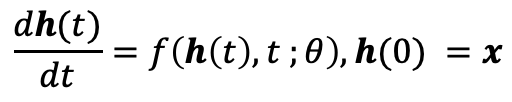


In [ ]:
args.model = 'node'
print(args.model)

In [ ]:
class anode_initial_velocity(nn.Module):

    def __init__(self, in_channels, aug, args):
        super(anode_initial_velocity, self).__init__()
        self.args = args
        self.aug = aug
        self.in_channels = in_channels

    def forward(self, x0):
        x0 = rearrange(x0.float(), 'b c x y -> b 1 c x y')
        outshape = list(x0.shape)
        outshape[2] = self.aug
        out = torch.zeros(outshape).to(self.args.gpu)
        out[:, :, :3] += x0
        return out

In [ ]:
class NODE(nn.Module):
    def __init__(self, df=None, **kwargs):
        super(NODE, self).__init__()
        self.__dict__.update(kwargs)
        self.df = df
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        return self.df(t, x)

In [ ]:
dim = 3
hidden = 125
df = models.DF(dim, hidden, args=args)
model_layer = models.NODElayer(NODE(df), args=args)
iv = models.anode_initial_velocity(3, aug=dim, args=args)
# create the model
model = nn.Sequential(
    iv,
    model_layer,
    models.predictionlayer(dim)
    ).to(device=f'cuda:{args.gpu}')

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# print some summary information
print(f'Error Tolerance: {args.tol}')
print('Model Parameter Count:', utils.count_parameters(model))

# train the model
PATH = './model/cifar10_node_10.pt'
model.load_state_dict(torch.load(PATH))

utils.test(model, optimizer, trdat, tsdat, args=args)

# Augmented Neural ODE (ANODE)

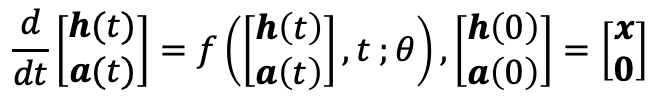










In [ ]:
args.model = 'anode'
print(args.model)

In [ ]:
class anode_initial_velocity(nn.Module):

    def __init__(self, in_channels, aug, args):
        super(anode_initial_velocity, self).__init__()
        self.args = args
        self.aug = aug
        self.in_channels = in_channels

    def forward(self, x0):
        x0 = rearrange(x0.float(), 'b c x y -> b 1 c x y')
        outshape = list(x0.shape)
        outshape[2] = self.aug
        out = torch.zeros(outshape).to(self.args.gpu)
        out[:, :, :3] += x0
        return out

In [ ]:
class NODE(nn.Module):
    def __init__(self, df=None, **kwargs):
        super(NODE, self).__init__()
        self.__dict__.update(kwargs)
        self.df = df
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        return self.df(t, x)

In [ ]:
dim = 13
hidden = 64
df = models.DF(dim, hidden, args=args)
model_layer = models.NODElayer(NODE(df), args=args)
iv = models.anode_initial_velocity(3, aug=dim, args=args)
# create the model
model = nn.Sequential(
    iv,
    model_layer,
    models.predictionlayer(dim)
    ).to(device=f'cuda:{args.gpu}')

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# print some summary information
print(f'Error Tolerance: {args.tol}')
print('Model Parameter Count:', utils.count_parameters(model))

# train the model
PATH = './model/cifar10_anode_10.pt'
model.load_state_dict(torch.load(PATH))

utils.test(model, optimizer, trdat, tsdat, args=args)

# Second order Neural ODE (SONODE)
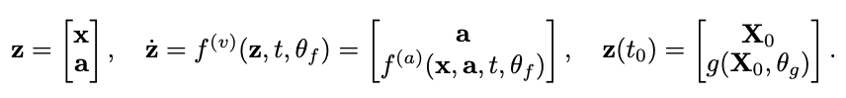

In [ ]:
args.model = 'sonode'
print(args.model)

In [ ]:
class initial_velocity(nn.Module):

    def __init__(self, in_channels, out_channels, nhidden):
        super(initial_velocity, self).__init__()
        assert (3 * out_channels >= in_channels)
        self.actv = nn.LeakyReLU(0.3)
        self.fc1 = nn.Conv2d(in_channels, nhidden, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(nhidden, nhidden, kernel_size=3, padding=1)
        self.fc3 = nn.Conv2d(nhidden, 2 * out_channels - in_channels, kernel_size=1, padding=0)
        self.out_channels = out_channels
        self.in_channels = in_channels

    def forward(self, x0):
        x0 = x0.float()
        out = self.fc1(x0)
        out = self.actv(out)
        out = self.fc2(out)
        out = self.actv(out)
        out = self.fc3(out)
        out = torch.cat([x0, out], dim=1)
        out = rearrange(out, 'b (d c) ... -> b d c ...', d=2)
        return out

In [ ]:
class SONODE(NODE):
    def forward(self, t, x):
        """
        Compute [y y']' = [y' y''] = [y' df(t, y, y')]
        :param t: time, shape [1]
        :param x: [y y'], shape [batch, 2, vec]
        :return: [y y']', shape [batch, 2, vec]
        """
        self.nfe += 1
        v = x[:, 1:, :]
        out = self.df(t, x)
        return torch.cat((v, out), dim=1)

In [ ]:
dim = 12
hidden = 50
df = models.DF(dim, hidden, args=args)
model_layer = models.NODElayer(SONODE(df), args=args)
iv = models.initial_velocity(3, dim, hidden)

# create the model
model = nn.Sequential(
    iv,
    model_layer,
    models.predictionlayer(dim)
    ).to(device=f'cuda:{args.gpu}')

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# print some summary information
print(f'Error Tolerance: {args.tol}')
print('Model Parameter Count:', utils.count_parameters(model))

# train the model
PATH = './model/cifar10_sonode_10.pt'
model.load_state_dict(torch.load(PATH))

utils.test(model, optimizer, trdat, tsdat, args=args)

# (General) Heavy ball Neural ODE ((G)HBNODE)

## HBNODE
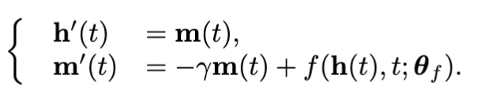
## GHBNODE
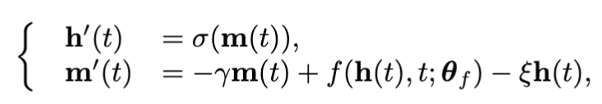

In [ ]:
args.model = 'hbnode'
print(args.model)

In [ ]:
class initial_velocity(nn.Module):

    def __init__(self, in_channels, out_channels, nhidden):
        super(initial_velocity, self).__init__()
        assert (3 * out_channels >= in_channels)
        self.actv = nn.LeakyReLU(0.3)
        self.fc1 = nn.Conv2d(in_channels, nhidden, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(nhidden, nhidden, kernel_size=3, padding=1)
        self.fc3 = nn.Conv2d(nhidden, 2 * out_channels - in_channels, kernel_size=1, padding=0)
        self.out_channels = out_channels
        self.in_channels = in_channels

    def forward(self, x0):
        x0 = x0.float()
        out = self.fc1(x0)
        out = self.actv(out)
        out = self.fc2(out)
        out = self.actv(out)
        out = self.fc3(out)
        out = torch.cat([x0, out], dim=1)
        out = rearrange(out, 'b (d c) ... -> b d c ...', d=2)
        return out

In [ ]:
class HeavyBallNODE(NODE):
    def __init__(self, df, gamma=None, thetaact=None, gammaact='sigmoid', timescale=1):
        super().__init__(df)
        self.gamma = nn.Parameter(torch.Tensor([-3.0])) if gamma is None else gamma
        self.gammaact = nn.Sigmoid() if gammaact == 'sigmoid' else gammaact
        self.timescale = timescale
        self.thetaact = nn.Identity() if thetaact is None else thetaact

    def forward(self, t, x):
        """
        Compute [theta' m' v'] with heavy ball parametrization in
        $$ theta' = -m / sqrt(v + eps) $$
        $$ m' = h f'(theta) - rm $$
        $$ v' = p (f'(theta))^2 - qv $$
        https://www.jmlr.org/papers/volume21/18-808/18-808.pdf
        because v is constant, we change c -> 1/sqrt(v)
        c has to be positive
        :param t: time, shape [1]
        :param x: [theta m v], shape [batch, 3, dim]
        :return: [theta' m' v'], shape [batch, 3, dim]
        """
        self.nfe += 1
        theta, m = torch.split(x, 1, dim=1)
        dtheta = self.thetaact(m)
        dm = self.df(t, theta) - self.timescale * torch.sigmoid(self.gamma) * m
        return torch.cat((dtheta, dm), dim=1)

In [ ]:
# hbnode

dim = 12
hidden = 51
args.xres = 0
df = models.DF(dim, hidden, args=args)
iv = models.initial_velocity(3, dim, hidden)
model_layer = models.NODElayer(HeavyBallNODE(df, None, thetaact=None, timescale=args.timescale), args=args)

model = nn.Sequential(
    iv,
    model_layer,
    models.predictionlayer(dim)
    ).to(device=f'cuda:{args.gpu}')

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# print some summary information
print(f'Error Tolerance: {args.tol}')
print('Model Parameter Count:', utils.count_parameters(model))

# train the model
PATH = './model/cifar10_hbnode_10.pt'
model.load_state_dict(torch.load(PATH))

utils.test(model, optimizer, trdat, tsdat, args=args)

In [ ]:
args.model = 'ghbnode'
print(args.model)

In [ ]:
# ghbnode

dim = 12
hidden = 51
args.xres = 1.5
df = models.DF(dim, hidden, args=args)
model_layer = models.NODElayer(HeavyBallNODE(df, None, thetaact=thetaact, timescale=args.timescale), args=args) 
iv = models.initial_velocity(3, dim, hidden)
model = nn.Sequential(
    iv,
    model_layer,
    models.predictionlayer(dim)
    ).to(device=f'cuda:{args.gpu}')

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# print some summary information
print(f'Error Tolerance: {args.tol}')
print('Model Parameter Count:', utils.count_parameters(model))

# train the model
PATH = './model/cifar10_ghbnode_10.pt'
model.load_state_dict(torch.load(PATH))

utils.test(model, optimizer, trdat, tsdat, args=args)

# Adaptive momentum estimation Neural ODE (AdamNODE)

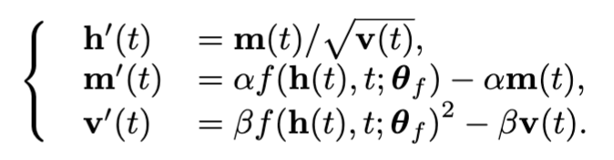

In [ ]:
args.model = 'adamnode'
print(args.model)

In [ ]:
class initial_velocity_adam(nn.Module):

    def __init__(self, in_channels, out_channels, nhidden):
        super(initial_velocity_adam, self).__init__()
        assert (3 * out_channels >= in_channels)
        self.actv = nn.LeakyReLU(0.3)
        self.fc1 = nn.Conv2d(in_channels, nhidden, kernel_size=1, padding=0) # 3, 51
        self.fc2 = nn.Conv2d(nhidden, nhidden, kernel_size=3, padding=1) # 51, 51
        self.fc3 = nn.Conv2d(nhidden, 2 * out_channels - in_channels, kernel_size=1, padding=0) # 51, 21

        self.out_channels = out_channels # 12
        self.nhidden = nhidden # 51
        self.in_channels = in_channels # 3

    def forward(self, x0):
        x0 = x0.float()

        out = self.fc1(x0)
        out = self.actv(out)
        out = self.fc2(out)
        out = self.actv(out)
        out = self.fc3(out)

        out_v = out ** 2
        
        out = torch.cat([x0, out, out_v], dim=1)
        out = rearrange(out, 'b (d c) ... -> b d c ...', d=3)

        return out

In [ ]:
class AdamNODE(NODE):
    def __init__(self, df, gamma=None, thetaact=None, gammaact='sigmoid', sqrt='sigmoid',alpha = -3.0, beta = -3.0, timescale=1):
        super().__init__(df)
        self.gamma = nn.Parameter(torch.Tensor([-3.0])) if gamma is None else gamma
        self.gammaact = nn.Sigmoid() if gammaact == 'sigmoid' else gammaact
        self.timescale = timescale
        self.thetaact = nn.Identity() if thetaact is None else thetaact

        self.alpha = nn.Parameter(torch.Tensor([alpha]))
        self.beta = nn.Parameter(torch.Tensor([beta]))

        self.epsilon = 1e-8
        
        if sqrt == 'sigmoid':
            self.act = nn.Sigmoid()
        elif sqrt == 'softplus':
            self.act = nn.Softplus()
        else:
            self.act = nn.Identity()

    def forward(self, t, x):
        
        """
        Compute [theta' m' v'] with heavy ball parametrization in
        $$ theta' = -m / sqrt(v + eps) $$
        $$ m' = h f'(theta) - rm $$
        $$ v' = p (f'(theta))^2 - qv $$
        https://www.jmlr.org/papers/volume21/18-808/18-808.pdf
        because v is constant, we change c -> 1/sqrt(v)
        c has to be positive
        :param t: time, shape [1]
        :param x: [theta m v], shape [batch, 3, dim]
        :return: [theta' m' v'], shape [batch, 3, dim]
        """
        self.nfe += 1

        theta, m, v = torch.tensor_split(x, 3, dim=1)

        dtheta = self.thetaact(m) / (torch.sqrt(self.act(v))+ self.epsilon)

        df = self.df(t, theta)

        dm = torch.sigmoid(self.alpha) * (df - m)
        dv = torch.sigmoid(self.beta) * (df**2 - v)
        return torch.cat((dtheta, dm, dv), dim=1)


In [ ]:
dim = dim_size
hidden = hidden_size
args.xres = 0
df = models.DF(dim, hidden, args=args)
iv = models.initial_velocity_adam(3, dim, hidden)
model_layer = models.NODElayer(models.AdamNODE(df, None, thetaact=None, sqrt=sqrt, alpha = alpha, beta = beta, timescale=args.timescale), args=args)
# create the model
model = nn.Sequential(
    iv,
    model_layer,
    models.predictionlayer_adam(dim)
    ).to(device=f'cuda:{args.gpu}')

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# print some summary information
print(f'Error Tolerance: {args.tol}')
print('Model Parameter Count:', utils.count_parameters(model))

# train the model
PATH = './model/cifar10_adamnode_10.pt'
model.load_state_dict(torch.load(PATH))

utils.test(model, optimizer, trdat, tsdat, args=args)